In [ ]:
import time # to calculate the annotation time
import re # regular expression
import networkx as nx # to calculate the shortest path between nodes in the parsing tree
from practnlptools.tools import Annotator # to extract dep_parse, syntatic_parse, srl, verbs, words, POS, NER, chunks
import pandas as pd
from datetime import datetime, timedelta
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint # print dictionaries nicer
from nxpd import draw # show in iptyhon
from IPython.display import display # to display images and draw objects 
from networkx.drawing.nx_agraph import write_dot
import sys
from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer
import nltk
import numpy as np
from collections import defaultdict

try:
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    raise ImportError("This example needs Graphviz and either PyGraphviz or Pydot")

%matplotlib inline

#import the other functions
%run -i 'main_functions.ipynb'
%run -i 'utility_functions.ipynb'
%run -i 'parameters.ipynb'

SEPARATE_SENT = True
SHOW_DP_PLOTS = False
SHOW_REL_EXTRACTIONS = False
NODE_SELECTION = True
MAX_ITERATION = -1 #-1 -> to try all
SAVE_GEFX = True
SAVE_PAIRWISE_RELS = True
SAVE_ALL_RELS = True


nltk.data.path.append("/media/data5/behnam/nltk_data");

annotator = Annotator()



'''
A few sample test cases:
#texts = ["the Church told all Catholic parents not to let their child get the MMR."]
#texts = ["Why Samsung Pay could gain an early lead in mobile payments."]
#texts = ["You would keep your child 's shot records at home and NOT submit that to the school...only your exemption from all shots ."]
#texts = ["Parents may use their philosophical beliefs exemption for ANY vaccine they choose to do so ; you may selectively vaccinate your child and exempt them out of other vaccines ; you may also exempt out of any and all vaccines and use your exemption that way , as well ."]
#texts = ["Here is the Hawaii immunization brochure , which states the exemption forms can also be obtained from the school : Immunization and TB code : Surprisingly , I do n't see anything about religiously exempting a child from the TB screening requirement in the code ."]
#texts.insert(0,"I like this product and I also like the other product.") ! Strange dep res -> prep_like
#texts.insert(0,"A medical exemption is out of the question - you 'd have to first find a doctor willing to exempt your child from all shots - not going to happen - and then have the medical exemption renewed every year . ") -> tokenizer failure
#texts.insert(0,"A state exemption is only to exempt a child from state requirements ; while in the states , the only time an exemption would come up is when using DODs schools or daycare in the states--the OP is going to Japan . ")
#texts.insert(0,"Even if the Church told all Catholic parents not to let their child get the MMR for instance , most parents would have to still be required to submit a religous exemption which would exempt all vaccines .")
'''
#texts.insert(0,"He doesn't like to buy food.")
all_rels_str = []
all_rels = []
output = []

start_time = time.time()
for ind, t_orig in enumerate(texts):
    if MAX_ITERATION >= 0:
        if ind > MAX_ITERATION:
            break
    t_sentences = []
    try:
        t_orig = t_orig.replace("-"," ")
        t_sentences = sent_tokenize(t_orig)
    except:
        print "Error in sentence tokenizer! - ", t_orig
    #print "number of sentences: ", len(t_sentences)
    for t in t_sentences:
        try:
            t_annotated = annotator.getAnnotations(t, dep_parse=True)
        except:
            print "Error in sentence annotation"
        try:
            g_dir = create_dep_graph(t_annotated)
            if g_dir is None:
                print "No extraction found"
                continue
            if SHOW_DP_PLOTS:
                plot_dep(g_dir,t)
            g_undir = g_dir.to_undirected()
        except:
            print "Unexpected error while extracting relations:", sys.exc_info()[0]
        rels_pure, rels_simp = get_relations(g_dir, t_annotated, option="SVO")
        rels = rels_pure#rels_simp
        if SHOW_REL_EXTRACTIONS:
            print ind, t, "\n"
            print "Simplifided Version:"
            print_relations(rels)
            print "More detailed Version:"
            print_relations(rels_pure)
        else:
            print ind,
        all_rels_str = all_rels_str + get_rels_str(rels) #For simply counting the exact strings
        all_rels = all_rels + rels # to later create a dataframe
        for r in rels:
            output_row = defaultdict(list)
            output_row = r.copy()
            output_row["original_text"] = t_orig
            output_row["sentence"] = t
            output.append(output_row)


end_time = time.time()
print "Relation Extraction Time: ", end_time-start_time , "(seconds) - ", (end_time-start_time)/60, "(min)"
print "***************STATISTICS***************"
print "Total number of input records (posts): ", len(texts)
print "Total number of extracted relations: ", len(all_rels_str)
print_top_relations(all_rels_str,top_num=-1) 

df_rels = pd.DataFrame(all_rels)
df_output = pd.DataFrame(output)
print df_output

if SAVE_ALL_RELS:
    columns = ['original_text', 'sentence','arg1','rel','arg2','type','pattern','arg1_with_pos','rel_with_pos']#,'arg2_with_pos']
    df_output.to_csv("../data/output_relations.csv",sep=',', encoding='utf-8',header=True, columns=columns)
    #save_df_rels(df_rels)
if NODE_SELECTION:
    # get the list of different versions of an entity. Example : parents,parent,i,we -> parents
    entity_versions = get_entity_versions("mothering")    
    df_simp = get_simp_df(df_rels.copy(),entity_versions)  
    selected_nodes = entity_versions.keys()
    df_rels_selected = filter_nodes(df_simp.copy(),source='arg1',target='arg2',selected_nodes = selected_nodes)
    g_arg = create_argument_multiGraph(df_rels_selected.copy(),source='arg1',target='arg2',edge_attr = 'rel')
    if SAVE_GEFX:
        nx.write_gexf(g_arg, "../gephi_data/g_arg_selected_"+str(MAX_ITERATION)+"_"+str(time.time())+".gexf")
    plot_argument_graph(g_arg)
    if SAVE_PAIRWISE_RELS:
        file_loc = "../data/pairwise_rels_selected_"+str(MAX_ITERATION)+"_"+DATA_SET+".txt"
        save_pairwise_rels(file_loc,g_arg,print_option=True)      

g_arg = create_argument_multiGraph(df_rels.copy(),source='arg1',target='arg2',edge_attr = 'rel')
if SAVE_GEFX:
    nx.write_gexf(g_arg, "../gephi_data/g_arg_"+str(MAX_ITERATION)+"_"+str(time.time())+".gexf")
plot_argument_graph(g_arg)
if SAVE_PAIRWISE_RELS:
    file_loc = "../data/pairwise_rels_"+str(MAX_ITERATION)+"_"+DATA_SET+".txt"
    save_pairwise_rels(file_loc,g_arg,print_option=True)    
    


<IPython.core.display.Javascript object>

Skipping line 44759: expected 1 fields, saw 2



No extraction found
0 0 No extraction found
0 0 Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
0 0 0 0 No extraction found
0 0 0 No extraction found
0 0 0 0 0 including-VBG-11  does not appeared as a separate node in parsing tree.
0 0 0 0 0 Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
0 0 0 0 0 0 0 0 0 0 No extraction found
1 1 1 1 1 No extraction found
1 1 1 Tokenizer failed during parsing, Ex. there might be a dash in the sentence!
No extraction found
1 1 1 1 1 1 1 1 1 1 1 No extraction found


In [68]:
entity = "government"
df_simp[np.logical_and(df_simp['arg1']==entity,df_simp['arg2']==entity)]

arg1  \
67                              government   
118                             government   
209                           {legislator}   
235   a short religious exemption {letter}   
336   a short religious exemption {letter}   
427                                parents   
500                             government   
504                                   {it}   
512                             government   
515                             government   
578                             government   
589                             government   
692                                   {it}   
702                             government   
705                             government   
709                                   {it}   
764                                schools   
789                                parents   
878                                schools   
892                                parents   
1188                            government   
1465                                {they}   
1602                                {they}   
1715                            government   
1863                               parents   
2122                               parents   
2217                            government   
2331                            government   
2658                                {they}   
2659                                {they}   
2660                                {they}   
2661                                {they}   
2662                                {they}   
2667                               parents   
2700                            government   
3570                            government   
3574                                  {it}   
3600                            government   
3603                            government   
3862                                {they}   
3863                                {they}   
3868                               parents   
3890                            government   
4476                            government   
4500                            government   
4503                            government   
5023                            government   
5228                            government   
5434                            government   
5791                            government   
5839                                {they}   
5920                               schools   
5935                            government   
6060                          {legislator}   
6227                            government   
6334                            government   
6657                            government   

                                          arg1_with_pos         arg2  \
67                                            law-NN-33      schools   
118                                           law-NN-33      schools   
209                                    legislator-NN-42   government   
235   a-DT-22 short-JJ-23 religious-JJ-24 exemption-...   government   
336   a-DT-22 short-JJ-23 religious-JJ-24 exemption-...   government   
427                                           you-PRP-9   government   
500                                           law-NN-33      schools   
504                                            It-PRP-1   government   
512                                 the-DT-11 law-NN-12       {more}   
515                                 the-DT-11 law-NN-12       {more}   
578                                 the-DT-11 law-NN-12       {more}   
589                            the-DT-6 government-NN-7         {me}   
692                                            it-PRP-3   government   
702                                   no-DT-9 law-NN-10     vaccines   
705                                           law-NN-33      schools   
709                                            It-PRP-1   government   
764                          Private-JJ-1 schools-NNS-2   government   
789                                           you-PRP-9   government   
8

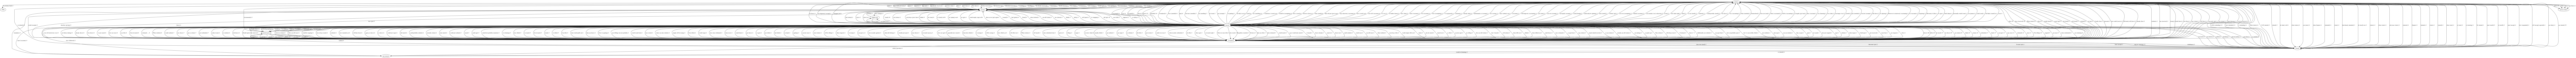

medical prof vaccines {0: {'label': 'how {got}-2'}}
medical prof parents {0: {'label': '{informed} up-2'}, 1: {'label': 'ca {rat} out-2'}}
medical prof children {0: {'label': '{recommends}-5'}}
medical prof exemptions {0: {'label': 'wo {sign}-6'}, 1: {'label': 'to {sign}-4'}, 2: {'label': '{supports}-4'}, 3: {'label': 'is {giving}-4'}, 4: {'label': '{used}-3'}, 5: {'label': 'has {signed}-2'}, 6: {'label': '{filled} out-1'}}
government vaccines {0: {'label': '{mandates}-3'}}
government schools {0: {'label': 'to {attend}-6'}}
government exemptions {0: {'label': 'calmly {provides}-1'}}
religous inst vaccines {0: {'label': '{forbids}-3'}}
religous inst parents {0: {'label': 'Even {told}-5'}}
vaccines religous inst {0: {'label': 'does {change}-5'}}
vaccines children {0: {'label': 'just {vaxing}-3'}}
vaccines exemptions {0: {'label': 'therefore {giving}-9'}, 1: {'label': '{have}-2'}}
parents medical prof {0: {'label': 'would {find}-16'}, 1: {'label': 'are having {getting}-6'}, 2: {'label': '

In [74]:
selected_nodes = entity_versions.keys()
df_rels_selected = filter_nodes(df_simp.copy(),source='arg1',target='arg2',selected_nodes = selected_nodes)
g_arg = create_argument_multiGraph(df_rels_selected.copy(),source='arg1',target='arg2',edge_attr = 'rel')
if SAVE_GEFX:
    nx.write_gexf(g_arg, "../gephi_data/g_arg_selected_2_"+str(MAX_ITERATION)+"_"+str(time.time())+".gexf")
plot_argument_graph(g_arg)
if SAVE_PAIRWISE_RELS:
    file_loc = "../data/pairwise_rels_selected_2_"+str(MAX_ITERATION)+"_"+DATA_SET+".txt"
    save_pairwise_rels(file_loc,g_arg,print_option=True)  

In [72]:
df_rels_selected

arg1                           arg1_with_pos           arg2  \
0     religous inst                   the-DT-3 Church-NNP-4        parents   
2        exemptions  a-DT-30 religous-JJ-31 exemption-NN-32       vaccines   
4           parents                               You-PRP-1       children   
5           parents                               you-PRP-2     exemptions   
12          parents                              you-PRP-16       children   
13          parents                              You-PRP-11       children   
14          parents                              you-PRP-18     exemptions   
15          parents                              you-PRP-26       vaccines   
24          parents                              you-PRP-10       children   
25          parents                              you-PRP-48        parents   
26          parents                              you-PRP-64       children   
27          parents                                 I-PRP-1       children   
28          parents                           Parents-NNS-4     exemptions   
30          parents                              you-PRP-20       children   
31          parents                           Parents-NNS-4     exemptions   
32          parents                              you-PRP-17     exemptions   
34          parents                              you-PRP-28       children   
40          parents                    a-DT-10 parent-NN-11     exemptions   
43          parents                              you-PRP-13       children   
44          parents                               you-PRP-5       children   
45          parents                               You-PRP-1     exemptions   
48          parents                              you-PRP-10     exemptions   
66          parents                the-DT-79 parents-NNS-80       children   
67       government                               law-NN-33        schools   
68          parents                              you-PRP-55     exemptions   
70          parents                                I-PRP-13     exemptions   
71          parents                               we-PRP-17     exemptions   
72          parents                               we-PRP-27       children   
76          parents                               You-PRP-1       children   
77          parents                               you-PRP-2     exemptions   
...             ...                                     ...            ...   
6577        parents                               you-PRP-2     exemptions   
6582        parents                                i-PRP-69   medical prof   
6584        parents                                i-PRP-69   medical prof   
6585        parents                             you-PRP-127     exemptions   
6589        parents                               you-PRP-5     exemptions   
6591        parents                               you-PRP-5     exemptions   
6602        parents                               you-PRP-6     exemptions   
6611        parents                               you-PRP-3       children   
6616        parents                              you-PRP-25       children   
6617        parents                                 I-PRP-1        parents   
6622        parents                                 I-PRP-1        parents   
6624        parents                                 I-PRP-3     exemptions   
6630        parents                              you-PRP-12     exemptions   
6636        parents                               us-PRP-19       vaccines   
6642        parents                                I-PRP-35     exemptions   
6655        parents                               we-PRP-52     exemptions   
6656       children                              child-NN-7        schools   
6657     government                       no-DT-9 law-NN-10       vaccines   
6660       children                     a-DT-22 child-NN-23     exemptions   
6664        parents                  

In [6]:
#t_orig = "Fortunately MN does not have a complicated exemption process when you do need one : If a notarized statement signed by the minor child 's parent or by the emancipated person is submitted to the person having supervision of the school or child care facility stating that the person has not been immunized as prescribed because of the conscientiously held beliefs of the parent of the minor child or of the emancipated person , the immunizations specified in the statement shall not be required ."
t_orig = "I 'd have to put it on my own words though or I d never remember what to say ~ laughs ~ ... how about...  Although vaccinations are required by law to attend school , there are simple , legal , ways to exempt your child from that requirement... in Colorado you can get an exemption for medical , religious , or even philisophical reasons .# and we just submitted a religious exemption to the school she will be attending this fall ."#"The principal opposition parties boycotted the polls after accusations of vote-rigging , and the only other name on the ballot was a little-known challenger from a marginal political party."
t_orig = t_orig.replace("-"," ")
t_sentences = sent_tokenize(t_orig)
for t in t_sentences:
    print t
    t_annotated = annotator.getAnnotations(t, dep_parse=True)
    print t_annotated
    dep = t_annotated['dep_parse']
    g_dir = create_dep_graph(t_annotated)
    if g_dir is None:
        print "No extraction found"
        continue
    #if SHOW_DP_PLOTS:
    plot_dep(g_dir,t)
    g_undir = g_dir.to_undirected()
    rels_pure, rels_simp = get_relations(g_dir, t_annotated, option="SVO")
    print rels_pure
    print "simplified"
    print rels_simp

I 'd have to put it on my own words though or I d never remember what to say ~ laughs ~ ... how about...


IOError: [Errno 13] Permission denied: '/usr/local/lib/python2.7/dist-packages/practnlptools/in.parse'

In [ ]:
2+2

In [20]:
t_annotated['srl']

[{'A0': 'Doctors and ER nurces and CPS workers',
  'A1': 'that you have an exemption that allows your child to attend school without getting the " required " vaccinations',
  'AM-MNR': 'in the slightest',
  'AM-MOD': 'will',
  'AM-NEG': 'not',
  'V': 'care'},
 {'A0': 'you',
  'A1': 'an exemption that allows your child to attend school',
  'AM-MNR': 'without getting the " required " vaccinations',
  'V': 'have'},
 {'A0': 'an exemption',
  'A1': 'your child to attend school without getting the " required " vaccinations',
  'R-A0': 'that',
  'V': 'allows'},
 {'A0': 'your child',
  'A1': 'school',
  'AM-MNR': 'without getting the " required " vaccinations',
  'V': 'attend'},
 {'A0': 'you  your child',
  'A1': 'the " required " vaccinations',
  'V': 'getting'},
 {'A1': 'vaccinations', 'A2': 'the "', 'V': 'required'}]

In [24]:
df_rels

arg1  \
0                           the {Church}   
1                                {child}   
2                 a religous {exemption}   
3     the Hawaii immunization {brochure}   
4                                  {You}   
5                                  {you}   
6                                   {it}   
7                                  {you}   
8                                  {you}   
9                                    {I}   
10                        an {exemption}   
11                       the only {time}   
12                                 {you}   
13                                 {You}   
14                                 {you}   
15                                 {you}   
16                                   {I}   
17                                {they}   
18                                   {I}   
19                                  {it}   
20                                  {we}   
21                              {notice}   
22                                 {you}   
23                                 {you}   
24                                 {you}   
25                                 {you}   
26                                 {you}   
27                                   {I}   
28                             {Parents}   
29                                {they}   
...                                  ...   
6660                           a {child}   
6661                            {sister}   
6662                               {she}   
6663                            {sister}   
6664                               {you}   
6665                               {you}   
6666                               {You}   
6667                             a {Dr.}   
6668                         a {vaccine}   
6669                               {you}   
6670                             {child}   
6671                               {you}   
6672                          that {one}   
6673                                 {i}   
6674                                 {i}   
6675                              {they}   
6676                          a {letter}   
6677                              {they}   
6678                                {us}   
6679                                 {I}   
6680                                {it}   
6681                                 {I}   
6682                                {it}   
6683                             {child}   
6684                            {sister}   
6685                               {she}   
6686                            {sister}   
6687                               {you}   
6688                               {you}   
6689                             {child}   

                                          arg1_with_pos  \
0                                 the-DT-3 Church-NNP-4   
1                                           child-NN-13   
2                a-DT-30 religous-JJ-31 exemption-NN-32   
3     the-DT-3 Hawaii-NNP-4 immunization-NN-5 brochu...   
4                                             You-PRP-1   
5                                             you-PRP-2   
6                                              it-PRP-8   
7                                             you-PRP-9   
8                                             you-PRP-9   
9                                               I-PRP-2   
10                             an-DT-22 exemption-NN-23   
11                      the-DT-19 only-JJ-20 time-NN-21   
12                                           you-PRP-16   
13                                           You-PRP-11   
14                                           you-PRP-18   
15                                           you-PRP-26   
16                                             I-PRP-17   
17                                          they-PRP-34   
18                                             I-PRP-47   
19                                            it-PRP-58   
20                                             we-PRP-6   
21       